# EU climate change mitigation targets compromise forest ecosystem services and biodiversity

## FINLAND

Above the code cells, there are short instructions how the users can modify the codes in the cells.<br>
If there are no instructions, no changes should be needed for the cell by default.

A detailed description is provided in the <b>README.md</b>.

## Basic definitions

Simulated forest data (climate scenario and name); sample size of data 

In [1]:
RCP = "RCP0"
filename = "rslt_"+RCP+"_CentralFinland.zip" # Test data from Central Finland with 3579 forest stands
sample = 0.5 # if 1, 100% of data is used 

Specify policy scenario:

* "NFS" - National Forest Strategy
* "BDS" - Biodiversity Strategy
* "BES" - Bioeconomy Strategy

In [2]:
scenario = "BES"

Name definition for saved output, rule: _scenario_RCP_extension

In [3]:
extension = "Test_BottomUp" # some additional info to the saved output

## Specify "if" and "which" GLOBIOM scenario is used

<b>ATTENTION:</b> each scenario relates to specific CC simulation!<br>
Three scenarios define the perdiodic future demand for log, pulp/fuelwood, and forest residues.

<b>Bottom-up</b> 
* 1.5 degrees + RCP 0 (no CC) = <b>'globiom_1p5_RCP0'</b>
* NDC + RCP 4.5 = <b>'globiom_NDC_RCP45'</b>

<b>Top-down</b> - functions <b>WITH</b> assortment transfer
* 1.5 = <b>'globiom_1p5_RCP0_V2'</b>
* NDC = <b>'globiom_NDC_RCP45_V2'</b>

If <b>objectives_globiom = ' '</b>, no GLOBIOM demand objectives are considered.

In [4]:
objectives_globiom = 'globiom_1p5_RCP0'  

## Read .py class

In [5]:
import wget
import os
import pandas as pd
import numpy as np
import sys

In [6]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/py_class")

import multiFunctionalOptimization as MFO

In [7]:
from importlib import reload
reload(MFO)

<module 'multiFunctionalOptimization' from '/home/ubuntu/workspace/mf_optimization_demo/py_class/multiFunctionalOptimization.py'>

In [8]:
mfo = MFO.MultiFunctionalOptimization(solver='CPLEX')

'Using CPLEX'

## Read data

In [9]:
%%time
mfo.readData(filename,
             # If no sample ratio given, the ratio is assumed to be 1
             sampleRatio = sample ,
             # Sample equally in all regions. 
             # Give the name of the column along the sampling should be equal (here region).             
             samplingSubsets = "region"
            )

CPU times: user 1.89 s, sys: 1.87 s, total: 3.76 s
Wall time: 3.76 s


## Create some new variables in the data

Calculate total (per stand) values from relative values

Calculate total (per stand) values from relative values:
* "Relative to Area" = simulated indicator value relate to one hectar -> scaled to represented area of NFI plot <br>
* ("Relative to volume" = indicator relates to standing Volume -> scaled to the represented volume of the plot) <br>
* ("Absolute Value" = takes the inticator value as it is)

In [10]:
columnTypes = {
    'i_Vm3':(float,"Relative to Area"),
    'Harvested_V':(float,"Relative to Area"),
    'Harvested_V_log_under_bark':(float,"Relative to Area"), 
    'Harvested_V_pulp_under_bark':(float,"Relative to Area"),
    'Harvested_V_under_bark':(float,"Relative to Area"), 
    'Biomass':(float,"Relative to Area"),
    'ALL_MARKETED_MUSHROOMS':(float,"Relative to Area"), 
    'BILBERRY':(float,"Relative to Area"), 
    'COWBERRY':(float,"Relative to Area"),
    'HSI_MOOSE':(float,"Relative to Area"),
    'CAPERCAILLIE':(float,"Relative to Area"), 
    'HAZEL_GROUSE':(float,"Relative to Area"), 
    'V_total_deadwood':(float,"Relative to Area"), 
    'N_where_D_gt_40':(float,"Relative to Area"),
    'prc_V_deciduous':(float,"Relative to Area"),
    'CARBON_SINK':(float,"Relative to Area"), 
    'Recreation':(float,"Relative to Area"),
    'Scenic':(float,"Relative to Area")
}

In [11]:
mfo.calculateTotalValuesFromRelativeValues(columnTypes=columnTypes)

List the new created columns: <br>
* Total_... hectare value multiplied by represented area (or volume)

In [12]:
[name for name in mfo.data.columns if "Total_" in name and "Relative" not in name]

['Total_i_Vm3',
 'Total_Harvested_V',
 'Total_Harvested_V_log_under_bark',
 'Total_Harvested_V_pulp_under_bark',
 'Total_Harvested_V_under_bark',
 'Total_Biomass',
 'Total_ALL_MARKETED_MUSHROOMS',
 'Total_BILBERRY',
 'Total_COWBERRY',
 'Total_HSI_MOOSE',
 'Total_CAPERCAILLIE',
 'Total_HAZEL_GROUSE',
 'Total_V_total_deadwood',
 'Total_N_where_D_gt_40',
 'Total_prc_V_deciduous',
 'Total_CARBON_SINK',
 'Total_Recreation',
 'Total_Scenic']

## Create new column:
1) Column indicating if regime is "CCF_3, CCF_4, BAUwGTR" (TRUE/FLASE) <br>
Important for ES Biodiversity, allowed regimes for conservation sites.

2) Column indicating if regime is "SA" (TRUE/FALSE)<br>
Important for ES Biodiversity, allowed regimes for statutory protection sites.

3) Column indicating if regime is "BAUwT_B, BAUwT_5_B, BAUwT_15_B, BAUwT_30_B, BAUwT_GTR_B" <br>
Important for ES Resillience, allowed regimes for climate change adaption.

4) Column indicating if regime is within all four CCF<br>
Important for ES Water under GLOBIOM V2 (enabled constraint -> soft target).

In [13]:
regimeClassNames = {"regimeClass0name":"CCF",
                    "regimeClass1name":"SA",
                    "regimeClass2name":"Broadleave",
                    "regimeClass3name":"AllCCF"}
regimeClassregimes = {"regimeClass0regimes":["CCF_3","CCF_4","BAUwGTR"],
                      "regimeClass1regimes":["SA"],
                      "regimeClass2regimes":["BAUwT_B", "BAUwT_5_B", "BAUwT_15_B", "BAUwT_30_B", "BAUwT_GTR_B"],
                      "regimeClass3regimes":["CCF_1","CCF_2","CCF_3","CCF_4"]}

In [14]:
mfo.addRegimeClassifications(regimeClassNames = regimeClassNames,regimeClassregimes=regimeClassregimes)

## New column for "soft target" of only CCF on peat (ES Water)

Implemented for Top-down: alternative to the enabled constraint "only CCF on peat", allows to explore changes when prioritizing GLOBIOM demands. 

In [15]:
# Column indicating if CCF and SA are on peat land - allowed regimes for water protection
mfo.data['CCFonPeat'] = np.where( 
    ( (mfo.data['AllCCF_forests'] == True ) & (mfo.data['PEAT'] == 1 ) ) | 
    ( (mfo.data['SA_forests'] == True) & (mfo.data['PEAT'] == 1 ) )
    , 1, 0
)

In [16]:
# Create subsample to get the total peat area
peat = mfo.data[["id","represented_area_by_NFIplot","PEAT"]]
peat = peat[(peat["PEAT"] == 1)]
peat = peat.drop_duplicates(['id'])
totalPeat = peat["represented_area_by_NFIplot"].sum() / sample # divide by the sample ratio !!
totalPeat

244552.0

In [17]:
len(peat)

308

In [18]:
# Column defining a peat stand´s area in relation to total peat area (USED for OPTIMIZATION)
mfo.data['peatCCFArea'] = np.where(
    (mfo.data['CCFonPeat'] == 1 ), mfo.data['represented_area_by_NFIplot'] / totalPeat, 0
)

## Define initial value:
1) Define initial values; initial state is recognized by the regime "initial_state"

2) Create new variables that describe the <b>relative change to initial situation (start year) "Relative_"</b>:

In [19]:
mfo.finalizeData(initialRegime="initial_state")

New variables created:

In [20]:
[name for name in mfo.data.columns if "Relative_" in name]

['Relative_V',
 'Relative_Age',
 'Relative_AGE_ba',
 'Relative_ALL_MARKETED_MUSHROOMS',
 'Relative_BILBERRY',
 'Relative_COWBERRY',
 'Relative_HSI_MOOSE',
 'Relative_CAPERCAILLIE',
 'Relative_HAZEL_GROUSE',
 'Relative_V_total_deadwood',
 'Relative_N_where_D_gt_40',
 'Relative_prc_V_deciduous',
 'Relative_CARBON_STORAGE_Update',
 'Relative_Recreation',
 'Relative_Scenic',
 'Relative_Total_ALL_MARKETED_MUSHROOMS',
 'Relative_Total_BILBERRY',
 'Relative_Total_COWBERRY',
 'Relative_Total_HSI_MOOSE',
 'Relative_Total_CAPERCAILLIE',
 'Relative_Total_HAZEL_GROUSE',
 'Relative_Total_V_total_deadwood',
 'Relative_Total_N_where_D_gt_40',
 'Relative_Total_prc_V_deciduous',
 'Relative_Total_Recreation',
 'Relative_Total_Scenic']

In [21]:
mfo.data.head()

V  i_Vm3  Harvested_V  Harvested_V_log_under_bark  \
id       year regime                                                           
99011014 2021 SA      409.58   7.20          0.0                         0.0   
         2026 SA      445.49   7.29          0.0                         0.0   
         2031 SA      480.72   7.17          0.0                         0.0   
         2036 SA      503.77   4.75          0.0                         0.0   
         2041 SA      518.69   3.13          0.0                         0.0   

                      Harvested_V_pulp_under_bark  Harvested_V_under_bark  \
id       year regime                                                        
99011014 2021 SA                              0.0                     0.0   
         2026 SA                              0.0                     0.0   
         2031 SA                              0.0                     0.0   
         2036 SA                              0.0                     0.0   
         2041 SA                              0.0                     0.0   

                      MAIN_SP    Age  AGE_ba  SC  ...  \
id       year regime                              ...   
99011014 2021 SA            2   84.0   83.53   1  ...   
         2026 SA            2   89.0   88.57   1  ...   
         2031 SA            2   94.0   93.60   1  ...   
         2036 SA            2   99.0   98.62   1  ...   
         2041 SA            2  104.0  103.63   1  ...   

                      Relative_Total_BILBERRY  Relative_Total_COWBERRY  \
id       year regime                                                     
99011014 2021 SA                          0.0                 0.000339   
         2026 SA                          0.0                 0.000329   
         2031 SA                          0.0                 0.000320   
         2036 SA                          0.0                 0.000314   
         2041 SA                          0.0                 0.000311   

                      Relative_Total_HSI_MOOSE  Relative_Total_CAPERCAILLIE  \
id       year regime                                                          
99011014 2021 SA                           0.0                          0.0   
         2026 SA                           0.0                          0.0   
         2031 SA                           0.0                          0.0   
         2036 SA                           0.0                          0.0   
         2041 SA                           0.0                          0.0   

                      Relative_Total_HAZEL_GROUSE  \
id       year regime                                
99011014 2021 SA                         0.000147   
         2026 SA                         0.000088   
         2031 SA                         0.000029   
         2036 SA                         0.000000   
         2041 SA                         0.000000   

                      Relative_Total_V_total_deadwood  \
id       year regime                                    
99011014 2021 SA                             0.002044   
         2026 SA                             0.003213   
         2031 SA                             0.004253   
         2036 SA                             0.004918   
         2041 SA                             0.005344   

                      Relative_Total_N_where_D_gt_40  \
id       year regime                                   
99011014 2021 SA                                 0.0   
         2026 SA                                 0.0   
         2031 SA                                 0.0   
         2036 SA                                 0.0   
         2041 SA                                 0.0   

                      Relative_Total_prc_V_deciduous  \
id       year regime                                   
99011014 2021 SA                            0.000082   
         2026 SA                            0.000082   
         2031 SA                            0.000082   
        

In [22]:
mfo.initialData.head()

,,,V,i_Vm3,Harvested_V,Harvested_V_log_under_bark,Harvested_V_pulp_under_bark,Harvested_V_under_bark,MAIN_SP,Age,AGE_ba,SC,...,Total_prc_V_deciduous,Total_CARBON_SINK,Total_Recreation,Total_Scenic,CCF_forests,SA_forests,Broadleave_forests,AllCCF_forests,CCFonPeat,peatCCFArea
id,year,regime,,,,,,,,,,,,,,,,,,,,,
99011014,2016,initial_state,374.02,0.0,0.0,0.0,0.0,0.0,2,80.0,79.48,1,...,1191.0,0.0,2503.879,2317.289,False,False,False,False,0,0.0
99011016,2016,initial_state,141.85,0.0,0.0,0.0,0.0,0.0,1,89.0,71.71,4,...,5161.0,0.0,2374.854,2432.816,False,False,False,False,0,0.0
99011019,2016,initial_state,142.53,0.0,0.0,0.0,0.0,0.0,1,60.0,57.78,4,...,0.0,0.0,2239.477,2069.561,False,False,False,False,0,0.0
99011020,2016,initial_state,238.93,0.0,0.0,0.0,0.0,0.0,1,85.0,74.00,4,...,1588.0,0.0,2317.289,2360.165,False,False,False,False,0,0.0
99011021,2016,initial_state,289.15,0.0,0.0,0.0,0.0,0.0,1,89.0,79.30,4,...,0.0,0.0,2408.202,2418.921,False,False,False,False,0,0.0


## GLOBIOM - Bottom-up

Read the targeted timber demands.

In [23]:
# -----------
# 1.5 degree scenario; matches with RCP0 (no CC)
# -----------
if objectives_globiom == 'globiom_1p5_RCP0':
    
    demands = pd.read_csv('FIN_globiom1p5_all.csv') 

    print("used 1p5")
    
    
# ----------- 
# NDC scenario, matches with RCP 4.5
# -----------
elif objectives_globiom == 'globiom_NDC_RCP45':
    
    demands = pd.read_csv('FIN_globiomNDC_all.csv') 

    print("used NDC") 


used 1p5


<b>For the Central Finland test data, national values are simply divided by 19 (number provinces in Finland).</b>

In [24]:
if objectives_globiom == 'globiom_1p5_RCP0' or objectives_globiom =='globiom_NDC_RCP45' :
    
    sawlog = demands["GSawlog_uB"] / 19 # divided by the number of provinces for test data
    sawlog = sawlog.to_list()
    
    pulpfuel = demands["GPulpFuel_uB"] / 19 
    pulpfuel = pulpfuel.to_list()

    residues = demands["GResidues"] / 19
    residues = residues.to_list()
    
    globiom = {
    # --------------
    # Sawlogs, millions m3/year under bark
    # --------------
    # max_periodicTargets_Sum_Objective
    "Total_Harvested_V_log_GLOBIOM" : ["GLOBIOM, total Sawlogs (m3/year, u. bark)",
                        "Total_Harvested_V_log_under_bark",
                        "max", "periodicTargets", "sum", sawlog],
    
    # --------------
    # Pulpwood (relates to pulp and fuelwood of GLOBIOM), millions m3/year under bark
    # --------------
    "Total_Harvested_V_pulp_GLOBIOM" : ["GLOBIOM, total Pulpwood (m3/year, u. bark)",
                        "Total_Harvested_V_pulp_under_bark",
                        "max", "periodicTargets", "sum", pulpfuel],
    
    # --------------
    # Biomass (relates to forest residues of GLOBIOM),  millions m3/year 
    # --------------
    "Total_Biomass_GLOBIOM" : ["GLOBIOM, total Biomass (m3/year)",
                        "Total_Biomass",
                        "max", "periodicTargets", "sum", residues] 
    }
    print("GLOBIOM Bottom-up loaded") 

else:
    globiom = {}
    print("no demands considered")

GLOBIOM Bottom-up loaded


## Define the optimization problem for policy scenarios
See README.md for details.

<b>Objective format:</b>

Unique_key :[Long human readable name, column name in data, max/min objective, year wise aggregation, stand wise aggregation (, target year )]

1) "Unique_key" : [ (2) "Long human readable name", (3) "column name", (4) "max/min objective", (5) "year wise aggregation", (6) "stand wise aggregation" (, (7) target year ) ]

<b>Options for "objective":</b> "max"imise or "min"imise it <br>
<b>year wise aggregation:</b> "min" (minimum value), "average", "firstYear", "targetYearWithSlope","targetYear","lastYear" <br>
<b>stand wise aggregation:</b> "sum", "areaWeightedAverage", "areaWeightedSum" <br>
<b>targe yeart:</b> any year except the first one

### NFS - National Forest Strategy

In [25]:
if scenario == 'NFS':
    
    wood_production_bioenergy = { 
    # Increment - target 2025
    "Total_i_Vm3_2025": ["Total annual timber volume increment by 2025 (m3)",
                         "Total_i_Vm3",
                         "max","targetYearWithSlope","sum",2025], 
    # Increment - target 2050
    "Total_i_Vm3_2050": ["Total annual timber volume increment by 2050 (m3)",
                         "Total_i_Vm3",
                         "max","targetYearWithSlope","sum",2050], 
    # Harvested roundwood - target 2025
    "Total_Harvested_V_2025" :["Total annual harvested timber volume by 2025 (log & pulp) (m3)",
                               "Total_Harvested_V",
                               "max","targetYearWithSlope","sum",2025], 
    # Harvested biomass - target 2025
    "Total_Biomass_2025": ["Total annual harvested biomass volume by 2025 (m3)",
                           "Total_Biomass",
                           "max","targetYearWithSlope","sum",2025]
    }
    
    nonwood = { 
    # Bilberry - no decline, maximise it
    "Relative_BILBERRY": ["Bilberry yield (relative to 2016, max minimum over yrs)",
                          "Relative_Total_BILBERRY",
                          "max","min","sum"],
    # Cowberry - no decline, maximise it
    "Relative_COWBERRY": ["Cowberry yield (relative to 2016, max minimum over yrs)",
                          "Relative_Total_COWBERRY",
                          "max","min","sum"],
    # Mushrooms - no decline, maximise it
    "Relative_ALL_MARKETED_MUSHROOMS": ["All marketed mushroom yield (relative to 2016, max minimum over yrs)",
                         "Relative_Total_ALL_MARKETED_MUSHROOMS",
                         "max","min","sum"]    
    }
    
    game = {
    # HSI moose - maximise  
    "Sum_Total_HSI_MOOSE": ["Total habitat index for MOOSE (max average over all years)",
                           "Total_HSI_MOOSE",
                           "max","average","sum"],
    # HSI hazel grouse - maximise
    "Sum_Total_HAZEL_GROUSE": ["Total habitat index for HAZEL_GROUSE (max average over yrs)",
                           "Total_HAZEL_GROUSE",
                           "max","average","sum"],
    # HSI capercaillie - maximise
    "Sum_Total_CAPERCAILLIE": ["Total habitat index for CAPERCAILLIE (max average over yrs)",
                           "Total_CAPERCAILLIE",
                           "max","average","sum"]    
    }
    
    biodiversity = {
    # Dearwood - target 2025
    "Average_Deadwood_V_2025": ["Average Deadwood volume by 2025 (m3/ha)", 
                                "V_total_deadwood",
                                "max", "targetYear", "areaWeightedAverage", 2025], 
    # Large trees (>40 cm) - maximise
    "Total_N_where_D_gt_40": ["Total No. of trees diameter >= 40 cm  (max end value)",
                              "Total_N_where_D_gt_40",
                              "max","lastYear","sum"],    
    # Deciduous tree volume - maximise
    "Total_prc_V_deciduous":  ["Total %-share of deciduous trees (related to V) (max end value)", 
                               "Total_prc_V_deciduous",
                               "max", "lastYear","sum"],
    # Conservation regime - target
    "Ratio_CCF_forests": ["Ratio of BC sites in commercial forests (%, CCF_3, CCF_4 and BAUwGTR)",
                          "CCF_forests",
                          "max","firstYear","areaWeightedAverage"]
    }
    
    climate_regulation = {
    # Carbon sink - target 2025
    "Total_CARBON_SINK_2025": ["Total sequestration in carbon dioxide by 2025 (t CO2)",
                               "Total_CARBON_SINK",
                               "max","targetYearWithSlope","sum",2025] 
    }
    
    recreation = {
    # Recreation index - maximise
    "Sum_Total_Recreation" : ["Total Recreation index (max minimum over yrs)",
                              "Total_Recreation",
                              "max","min","sum"],
    
    # Scenic index - maximise
    "Sum_Total_Scenic" : ["Total Scenic index (max minimum over yrs)",
                          "Total_Scenic",
                          "max","min","sum"]
    }
    
    resilience = {
    # CC adaption regimes - maximise
    "Ratio_Broadleave_forests": ["Ratio of adaptive management regimes (%, increasing broadleave share)",
                                 "Broadleave_forests",
                                 "max","firstYear","areaWeightedAverage"]
    }
    
    water = {
    # Scenario BAU & MF        
    # max_firstYear_AreaWeightedAverage
    "Ratio_CCF_onPeat" : ["Ratio of CCF on Peatland (%, all four CCF and SA)",
                         "peatCCFArea",
                         "max", "firstYear", "sum"]         
    }
    
    objectives = {
              **globiom,
              **wood_production_bioenergy,
              **nonwood,
              **game,
              **biodiversity,
              **climate_regulation,
              **recreation,
              **resilience,
              **water
    }
    
    print("objectives for NFS loaded")

### BDS - Biodiversity Strategy

In [26]:
if scenario == 'BDS':
    
    wood_production_bioenergy = { 
    # Harvested roundwood - maximise (even flow)
    "Average_Harvested_V" : ["Average harvested timber volume (log & pulp) (m3/ha, evenflow)",
                             "Harvested_V",
                             "max","min","areaWeightedAverage"]
    }
    
    game = {
    # HSI moose - maximise       
    "Sum_Total_HSI_MOOSE": ["Total habitat index for MOOSE (max average over all years)",
                           "Total_HSI_MOOSE",
                           "max","average","sum"],
    # HSI hazel grouse - maximise
    "Sum_Total_HAZEL_GROUSE": ["Total habitat index for HAZEL_GROUSE (max average over yrs)",
                           "Total_HAZEL_GROUSE",
                           "max","average","sum"],
    # HSI carpercaillie - maximise
    "Sum_Total_CAPERCAILLIE": ["Total habitat index for CAPERCAILLIE (max average over yrs)",
                           "Total_CAPERCAILLIE",
                           "max","average","sum"]    
    }
    
    biodiversity = {
    # Deadwood - target 2050, increase by XX%
    "relative_Amount_Deadwood_2050" : ["Total Deadwood volume by 2050 (%, relative to 2016 values)",
                                       "Relative_Total_V_total_deadwood",
                                       "max","targetYearWithSlope","sum",2050],
    # Large trees - target 2050, increase by XX%
    "relative_N_where_D_gt_40_2050": ["Total No. of trees diameter >= 40 cm  by 2050 (%, relative to 2016 values)",
                                      "Relative_Total_N_where_D_gt_40",
                                      "max","targetYear","sum",2050],
    # Deciduous tree volume - target 2050, increase by XX% 
    "relative_prc_V_deciduous_2050": ["Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)",
                                      "Relative_Total_prc_V_deciduous",
                                      "max","targetYearWithSlope","sum",2050],
    # Regime SA - target
    "Ratio_CCF_forests": ["Ratio of BC sites in commercial forests (%, CCF_3, CCF_4 and BAUwGTR)",
                          "CCF_forests",
                          "max","firstYear","areaWeightedAverage"],
    # Conservation regimes - target
    "Ratio_SA_forests": ["Ratio of protected areas (%, SA forests)",
                         "SA_forests",
                         "max","firstYear","areaWeightedAverage"]    
    
    }
    
    recreation = {
    # Recreation index - maximise
    "Sum_Total_Recreation" : ["Total Recreation index (max minimum over yrs)",
                              "Total_Recreation",
                              "max","min","sum"],
    # Scenic indes - maximise
    "Sum_Total_Scenic" : ["Total Scenic index (max minimum over yrs)",
                          "Total_Scenic",
                          "max","min","sum"]
    }
    
    objectives = {
                  **globiom,
                  **wood_production_bioenergy,
                  **game,
                  **biodiversity,
                  **recreation,
                  **water
    }
    
    print("objectives for BDS loaded")

### BES - Bioeconomy strategy

In [27]:
if scenario == 'BES':
    
    wood_production_bioenergy = { 
    # Harvested roundwood - maximise even flow
    "Average_Harvested_V" : ["Average harvested timber volume (log & pulp) (m3/ha, evenflow)",
                             "Harvested_V",
                             "max","min","areaWeightedAverage"],
    # Harvested biomass - maximise even flow
    "Biomass_Evenflow": ["Average harvested biomass volume (m3/ha, evenflow)",
                         "Biomass",
                         "max","min","areaWeightedAverage"]
    }
    
    biodiversity = {
    # Deadwood - no decline (no target value)
    "relative_Amount_Deadwood_2050" : ["Total Deadwood volume by 2050 (%, relative to 2016 values)",
                                       "Relative_Total_V_total_deadwood",
                                       "max","targetYearWithSlope","sum",2050],
    # Large trees - no decline (no target value)
    "relative_N_where_D_gt_40_2050": ["Total No. of trees diameter >= 40 cm  by 2050 (%, relative to 2016 values)",
                                      "Relative_Total_N_where_D_gt_40",
                                      "max","targetYear","sum",2050],
    # Deciduous tree volume - no decline (no target value)
    "relative_prc_V_deciduous_2050": ["Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)",
                                      "Relative_Total_prc_V_deciduous",
                                      "max","targetYearWithSlope","sum",2050]
    }
    
    recreation = {
    # Recreation index - maximise
    "Sum_Total_Recreation" : ["Total Recreation index (max minimum over all years)",
                              "Total_Recreation",
                              "max","min","sum"],
    # Scenic indes - maximise
    "Sum_Total_Scenic" : ["Total Scenic index (max minimum over all years)",
                          "Total_Scenic",
                          "max","min","sum"]
    }
    
    objectives = {
                  **globiom,
                  **wood_production_bioenergy,
                  **biodiversity,
                  **recreation,
    }
    
    print("objectives for BES loaded")

objectives for BES loaded


In [28]:
len(objectives)

10

In [29]:
objectives.keys()

dict_keys(['Total_Harvested_V_log_GLOBIOM', 'Total_Harvested_V_pulp_GLOBIOM', 'Total_Biomass_GLOBIOM', 'Average_Harvested_V', 'Biomass_Evenflow', 'relative_Amount_Deadwood_2050', 'relative_N_where_D_gt_40_2050', 'relative_prc_V_deciduous_2050', 'Sum_Total_Recreation', 'Sum_Total_Scenic'])

In [30]:
mfo.data.columns

Index(['V', 'i_Vm3', 'Harvested_V', 'Harvested_V_log_under_bark',
       'Harvested_V_pulp_under_bark', 'Harvested_V_under_bark', 'MAIN_SP',
       'Age', 'AGE_ba', 'SC', 'Biomass', 'ALL_MARKETED_MUSHROOMS', 'BILBERRY',
       'COWBERRY', 'HSI_MOOSE', 'CAPERCAILLIE', 'HAZEL_GROUSE',
       'V_total_deadwood', 'N_where_D_gt_40', 'prc_V_deciduous', 'PEAT',
       'clearcut', 'CARBON_SINK', 'CARBON_STORAGE_Update', 'Recreation',
       'Scenic', 'scenario', 'represented_area_by_NFIplot', 'region',
       'NUTS2_GL', 'protection', 'Total_i_Vm3', 'Total_Harvested_V',
       'Total_Harvested_V_log_under_bark', 'Total_Harvested_V_pulp_under_bark',
       'Total_Harvested_V_under_bark', 'Total_Biomass',
       'Total_ALL_MARKETED_MUSHROOMS', 'Total_BILBERRY', 'Total_COWBERRY',
       'Total_HSI_MOOSE', 'Total_CAPERCAILLIE', 'Total_HAZEL_GROUSE',
       'Total_V_total_deadwood', 'Total_N_where_D_gt_40',
       'Total_prc_V_deciduous', 'Total_CARBON_SINK', 'Total_Recreation',
       'Total_Sceni

In [31]:
[(col,mfo.data.dtypes[col]) for col in mfo.data.columns if "prc" in col]

[('prc_V_deciduous', dtype('float64')),
 ('Total_prc_V_deciduous', dtype('float64')),
 ('Relative_prc_V_deciduous', dtype('float64')),
 ('Relative_Total_prc_V_deciduous', dtype('float64'))]

## Define initial values NOT available in data, but needed for objective

Examples are increment, harvests, biomass and carbon sink. They are required for the "targetYearWithSlope" objective, but values only occur after the first simulation period. National values are taken from the policy or forest statistics. 

<b>For the Central Finland test data, national values are simply divided by 19 (number of considered provinces).</b> 

In [32]:
initialValues = {"Total_i_Vm3":107*10**6 / 19,               # value from National Forest Policy
                 "Total_Harvested_V": 72.3*10**6 / 19,       # value from National Forest Policy
                 "Total_Biomass": 2.9*10**6 / 19,            # value from National Forest Policy
                 "Total_CARBON_SINK" : 34.1*10**6 / 19,      # value from National Forest Policy
                                 
                 "SA_forests" : 0.106,     # from ForestStatistics 2018
                 "CCF_forests" : 0.015,    # from ForestStatistics 2018
                 "BAUwGTR_forests":0.015}  # from ForestStatistics 2018

In [33]:
mfo.defineObjectives(objectives,initialValues = initialValues)

'Defining objectives'

'Aggregating stand wise'

100%|██████████| 10/10 [01:11<00:00,  7.19s/it]


'Aggregating year wise'

100%|██████████| 10/10 [00:00<00:00, 2551.90it/s]


'Objectives added'

## GLOBIOM - Top-down (with option for assortment transfer)

<b>Attention: Has to be run after defining the objectives!</b>

Read the targeted timber demands. 

In [34]:
# -----------
# 1.5 degree scenario; matches with RCP0 (no CC)
# -----------
if objectives_globiom == 'globiom_1p5_RCP0_V2':
    
    demands = pd.read_csv('FIN_globiom1p5_all.csv') 

    print("used 1p5")
    
# ----------- 
# NDC scenario, matches with RCP 4.5
# -----------
elif objectives_globiom == 'globiom_NDC_RCP45_V2':
    
    demands = pd.read_csv('FIN_globiomNDC_all.csv') 

    print("used NDC")

<b>For the Central Finland test data, national values are simply divided by 19 (number provinces in Finland).</b>

In [35]:
if objectives_globiom == 'globiom_1p5_RCP0_V2' or objectives_globiom =='globiom_NDC_RCP45_V2' :
    
    sawlog = demands["GSawlog_uB"] / 19 # divided by the number of provinces for test data
    sawlog = sawlog.to_list()
    
    pulpfuel = demands["GPulpFuel_uB"] / 19 
    pulpfuel = pulpfuel.to_list()

    residues = demands["GResidues"] / 19 
    residues = residues.to_list()
    
    mfo.addGlobiomTargets(
        {
        "log": sawlog,
        "pulp": pulpfuel,
        "residues": residues
        },
        {
            #Log is converted primarily into log, and sencondary into pulp; no transferrate, both are volumes under bark
            "Total_Harvested_V_log_under_bark":
                {"log":[1,"primary"],"pulp":[1,"secondary"], "residues":[1.136,"secondary"]},
                #{"log":[1,"primary"],"pulp":[1,"secondary"]}, 
                                          
            # Pulp is converted primarily into pulp, and sencondary into residues; 
            # with transferrate 1.136, because pulp volume is under bark, residues are over bark (barkfactor = 1.136)  
            "Total_Harvested_V_pulp_under_bark":
                {"pulp":[1,"primary"], "residues":[1.136,"secondary"]}, 
            
            "Total_Biomass":
                {"residues":[1,"primary"]} #Biomass only to residues
        }, 
        
        # ----------------
        # by default exactMatching is FALSE
        # ----------------
        # Functionality was implemented for Norway and their nationl policy scenarios
        # NOT required for Cross-scale analysis V2
        exactMatching=False 
        
    )
    
    print("GLOBIOM Top-down loaded") 

else:
    globiom = {}
    print("no demands considered")

no demands considered


## Define enabled constraints

In [36]:
CCFregimes = [regime for regime in mfo.regimes if "CCF" in regime] + ["SA"]

In [37]:
CCFregimes

['CCF_1', 'CCF_2', 'CCF_3', 'CCF_4', 'SA']

Constraint format:
- Shortname: "constraint type","allowed regimes","human readable name",(regimes),"column in data")

In [38]:
constraintTypes = {"CCFonPeat":["Allowed regimes","Only CCF on peat lands",CCFregimes,"PEAT"]}

In [39]:
mfo.defineConstraints(constraintTypes)

## Calculate objective ranges
The ideal and anti-ideal solution for the individual objective functions.

In [40]:
mfo.data

V  i_Vm3  Harvested_V  Harvested_V_log_under_bark  \
id       year regime                                                           
99011014 2021 SA      409.58   7.20         0.00                        0.00   
         2026 SA      445.49   7.29         0.00                        0.00   
         2031 SA      480.72   7.17         0.00                        0.00   
         2036 SA      503.77   4.75         0.00                        0.00   
         2041 SA      518.69   3.13         0.00                        0.00   
...                      ...    ...          ...                         ...   
99043411 2116 CCF_1   133.70   4.66         0.00                        0.00   
              CCF_2    90.95   5.64        21.71                        8.22   
              CCF_3   164.46   4.69         0.00                        0.00   
              CCF_4   237.52   4.70         0.00                        0.00   
              SA      212.45   0.47         0.00                        0.00   

                      Harvested_V_pulp_under_bark  Harvested_V_under_bark  \
id       year regime                                                        
99011014 2021 SA                             0.00                    0.00   
         2026 SA                             0.00                    0.00   
         2031 SA                             0.00                    0.00   
         2036 SA                             0.00                    0.00   
         2041 SA                             0.00                    0.00   
...                                           ...                     ...   
99043411 2116 CCF_1                          0.00                    0.00   
              CCF_2                         10.63                   18.85   
              CCF_3                          0.00                    0.00   
              CCF_4                          0.00                    0.00   
              SA                             0.00                    0.00   

                      MAIN_SP    Age  AGE_ba  SC  ...  \
id       year regime                              ...   
99011014 2021 SA            2   84.0   83.53   1  ...   
         2026 SA            2   89.0   88.57   1  ...   
         2031 SA            2   94.0   93.60   1  ...   
         2036 SA            2   99.0   98.62   1  ...   
         2041 SA            2  104.0  103.63   1  ...   
...                       ...    ...     ...  ..  ...   
99043411 2116 CCF_1         6  138.8  108.70   3  ...   
              CCF_2         6  138.8  103.28   3  ...   
              CCF_3         6  138.8  121.35   3  ...   
              CCF_4         6  138.8  132.80   3  ...   
              SA            3  138.8  138.79   3  ...   

                      Relative_Total_BILBERRY  Relative_Total_COWBERRY  \
id       year regime                                                     
99011014 2021 SA                     0.000000                 0.000339   
         2026 SA                     0.000000                 0.000329   
         2031 SA                     0.000000                 0.000320   
         2036 SA                     0.000000                 0.000314   
         2041 SA                     0.000000                 0.000311   
...                                       ...                      ...   
99043411 2116 CCF_1                  0.000882                 0.000336   
              CCF_2                  0.000535                 0.000382   
              CCF_3                  0.000814                 0.000315   
              CCF_4                  0.000936                 0.000276   
              SA                     0.000908                 0.000266   

                      Relative_Total_HSI_MOOSE  Relative_Total_CAPERCAILLIE  \
id       year regime                                                          
99011014 2021 SA                           0.0                          0.0   
         2026 SA                          

In [41]:
%%time
mfo.calculateObjectiveRanges(debug=True)

'Calculating objective ranges'

  0%|          | 0/10 [00:00<?, ?it/s]

'Optimizing for GLOBIOM, total Sawlogs (m3/year, u. bark)'

'Found an optimal solution in 1 seconds'

'Objective values are:'

'GLOBIOM, total Sawlogs (m3/year, u. bark)'

1.362537000643552

'GLOBIOM, total Pulpwood (m3/year, u. bark)'

-0.571933107106819

'GLOBIOM, total Biomass (m3/year)'

-0.8248955866033547

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

3.5414379039919774

'Average harvested biomass volume (m3/ha, evenflow)'

0.06888987066459282

'Total Deadwood volume by 2050 (%, relative to 2016 values)'

1.0802776569177868

'Total No. of trees diameter >= 40 cm  by 2050 (%, relative to 2016 values)'

0.9845207803223072

'Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

0.7784737007543354

'Total Recreation index (max minimum over all years)'

7060749.1443314105

'Total Scenic index (max minimum over all years)'

6490754.933517867

 10%|█         | 1/10 [00:05<00:47,  5.30s/it]

'Optimizing for GLOBIOM, total Pulpwood (m3/year, u. bark)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'GLOBIOM, total Sawlogs (m3/year, u. bark)'

-0.031237035724727025

'GLOBIOM, total Pulpwood (m3/year, u. bark)'

0.025786499518185364

'GLOBIOM, total Biomass (m3/year)'

-0.47427836782892896

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

3.678140413849255

'Average harvested biomass volume (m3/ha, evenflow)'

0.2915930687534935

'Total Deadwood volume by 2050 (%, relative to 2016 values)'

0.7285512279907059

'Total No. of trees diameter >= 40 cm  by 2050 (%, relative to 2016 values)'

1.9030958439355385

'Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

0.2986200224430404

'Total Recreation index (max minimum over all years)'

6415318.105113068

'Total Scenic index (max minimum over all years)'

5746735.572063065

 20%|██        | 2/10 [00:09<00:40,  5.07s/it]

'Optimizing for GLOBIOM, total Biomass (m3/year)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'GLOBIOM, total Sawlogs (m3/year, u. bark)'

0.1583140805711838

'GLOBIOM, total Pulpwood (m3/year, u. bark)'

-0.5604407257796142

'GLOBIOM, total Biomass (m3/year)'

0.3076849201792899

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

2.3152050353928524

'Average harvested biomass volume (m3/ha, evenflow)'

0.36824110402622506

'Total Deadwood volume by 2050 (%, relative to 2016 values)'

1.2178275768440023

'Total No. of trees diameter >= 40 cm  by 2050 (%, relative to 2016 values)'

3.3447837150127233

'Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

0.10319511846489958

'Total Recreation index (max minimum over all years)'

6854038.9822814455

'Total Scenic index (max minimum over all years)'

6205274.233099028

 30%|███       | 3/10 [00:14<00:33,  4.80s/it]

'Optimizing for Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'GLOBIOM, total Sawlogs (m3/year, u. bark)'

0.7733941888732636

'GLOBIOM, total Pulpwood (m3/year, u. bark)'

-0.4485319554535424

'GLOBIOM, total Biomass (m3/year)'

-0.5228466016208673

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

5.153204327374458

'Average harvested biomass volume (m3/ha, evenflow)'

0.2697866988702478

'Total Deadwood volume by 2050 (%, relative to 2016 values)'

0.8548514500298731

'Total No. of trees diameter >= 40 cm  by 2050 (%, relative to 2016 values)'

0.5831212892281596

'Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

0.4720974826498292

'Total Recreation index (max minimum over all years)'

6752512.893602778

'Total Scenic index (max minimum over all years)'

6117077.43685122

 40%|████      | 4/10 [00:18<00:27,  4.57s/it]

'Optimizing for Average harvested biomass volume (m3/ha, evenflow)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'GLOBIOM, total Sawlogs (m3/year, u. bark)'

0.13259098417661797

'GLOBIOM, total Pulpwood (m3/year, u. bark)'

-0.5861259022431724

'GLOBIOM, total Biomass (m3/year)'

0.08529425003994817

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

3.3807522357965905

'Average harvested biomass volume (m3/ha, evenflow)'

0.6683348035327452

'Total Deadwood volume by 2050 (%, relative to 2016 values)'

1.1706924507518572

'Total No. of trees diameter >= 40 cm  by 2050 (%, relative to 2016 values)'

0.3333333333333334

'Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

0.08987359054095069

'Total Recreation index (max minimum over all years)'

6734729.643279576

'Total Scenic index (max minimum over all years)'

6080800.820732712

 50%|█████     | 5/10 [00:22<00:22,  4.43s/it]

'Optimizing for Total Deadwood volume by 2050 (%, relative to 2016 values)'

'Found an optimal solution in 1 seconds'

'Objective values are:'

'GLOBIOM, total Sawlogs (m3/year, u. bark)'

-1.0

'GLOBIOM, total Pulpwood (m3/year, u. bark)'

-1.0

'GLOBIOM, total Biomass (m3/year)'

-1.0

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

0.0

'Average harvested biomass volume (m3/ha, evenflow)'

0.0

'Total Deadwood volume by 2050 (%, relative to 2016 values)'

4.720384770498175

'Total No. of trees diameter >= 40 cm  by 2050 (%, relative to 2016 values)'

6.171755725190841

'Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

0.47829075810487737

'Total Recreation index (max minimum over all years)'

7468148.032000015

'Total Scenic index (max minimum over all years)'

6921648.154000009

 60%|██████    | 6/10 [00:26<00:17,  4.40s/it]

'Optimizing for Total No. of trees diameter >= 40 cm  by 2050 (%, relative to 2016 values)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'GLOBIOM, total Sawlogs (m3/year, u. bark)'

-0.5294121033300686

'GLOBIOM, total Pulpwood (m3/year, u. bark)'

-0.8658223709488482

'GLOBIOM, total Biomass (m3/year)'

-0.9964055089350004

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

1.2677697037451088

'Average harvested biomass volume (m3/ha, evenflow)'

0.0020346562325321404

'Total Deadwood volume by 2050 (%, relative to 2016 values)'

1.4998808680234317

'Total No. of trees diameter >= 40 cm  by 2050 (%, relative to 2016 values)'

20.39588634435963

'Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

1.0785950632899812

'Total Recreation index (max minimum over all years)'

6851637.9980000155

'Total Scenic index (max minimum over all years)'

6372434.383999997

 70%|███████   | 7/10 [00:30<00:12,  4.25s/it]

'Optimizing for Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'GLOBIOM, total Sawlogs (m3/year, u. bark)'

-0.15044292867452402

'GLOBIOM, total Pulpwood (m3/year, u. bark)'

-0.699361959977717

'GLOBIOM, total Biomass (m3/year)'

-0.9517948628821696

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

2.1196996842946887

'Average harvested biomass volume (m3/ha, evenflow)'

0.017238680827277808

'Total Deadwood volume by 2050 (%, relative to 2016 values)'

1.2253681239725307

'Total No. of trees diameter >= 40 cm  by 2050 (%, relative to 2016 values)'

3.9083969465648867

'Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

1.4016673177073269

'Total Recreation index (max minimum over all years)'

6775262.46587858

'Total Scenic index (max minimum over all years)'

6268736.370098854

 80%|████████  | 8/10 [00:34<00:08,  4.30s/it]

'Optimizing for Total Recreation index (max minimum over all years)'

'Found an optimal solution in 1 seconds'

'Objective values are:'

'GLOBIOM, total Sawlogs (m3/year, u. bark)'

-0.7577898449089683

'GLOBIOM, total Pulpwood (m3/year, u. bark)'

-0.7530392051229926

'GLOBIOM, total Biomass (m3/year)'

-0.7248575018050541

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

1.381117942984907

'Average harvested biomass volume (m3/ha, evenflow)'

0.08211850195640025

'Total Deadwood volume by 2050 (%, relative to 2016 values)'

3.172180353683614

'Total No. of trees diameter >= 40 cm  by 2050 (%, relative to 2016 values)'

11.091603053435117

'Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

0.5243277223133976

'Total Recreation index (max minimum over all years)'

7599694.349055961

'Total Scenic index (max minimum over all years)'

6922196.674700716

 90%|█████████ | 9/10 [00:39<00:04,  4.51s/it]

'Optimizing for Total Scenic index (max minimum over all years)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'GLOBIOM, total Sawlogs (m3/year, u. bark)'

-0.8169031446403655

'GLOBIOM, total Pulpwood (m3/year, u. bark)'

-0.814086498547115

'GLOBIOM, total Biomass (m3/year)'

-0.7717584416365824

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

1.1008044515817315

'Average harvested biomass volume (m3/ha, evenflow)'

0.08728339854667419

'Total Deadwood volume by 2050 (%, relative to 2016 values)'

3.4422622060704438

'Total No. of trees diameter >= 40 cm  by 2050 (%, relative to 2016 values)'

6.913273960983886

'Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

0.6053565045233318

'Total Recreation index (max minimum over all years)'

7560863.194247515

'Total Scenic index (max minimum over all years)'

6987017.443732449

100%|██████████| 10/10 [00:44<00:00,  4.43s/it]
CPU times: user 45.3 s, sys: 21.7 s, total: 1min 7s
Wall time: 44.3 s


In [42]:
mfo.objectiveRanges

{'Total_Harvested_V_log_GLOBIOM': (-1.0, 1.362537000643552),
 'Total_Harvested_V_pulp_GLOBIOM': (-1.0, 0.025786499518185364),
 'Total_Biomass_GLOBIOM': (-1.0, 0.3076849201792899),
 'Average_Harvested_V': (0.0, 5.153204327374458),
 'Biomass_Evenflow': (0.0, 0.6683348035327452),
 'relative_Amount_Deadwood_2050': (0.7285512279907059, 4.720384770498175),
 'relative_N_where_D_gt_40_2050': (0.3333333333333334, 20.39588634435963),
 'relative_prc_V_deciduous_2050': (0.08987359054095069, 1.4016673177073269),
 'Sum_Total_Recreation': (6415318.105113068, 7599694.349055961),
 'Sum_Total_Scenic': (5746735.572063065, 6987017.443732449)}

## Show GUI

* If "Enabled constraints" should be considered, start with ticking box "only CCF ..." and push "Change constraints"
* Epsilon constraints are only considered if sliders are moved and button "Set epsilon constraints" is pushed
* By pushing "OPTIMIZE" an optimal solution under the given constraints and reference points is searched

<b>SEE example figure below for scenario BES and Bottom-up.</b>

![image](./crossscaleGUI_FIN.PNG)

In [43]:
mfo.showGUI (debug=True)

interactive(children=(FloatSlider(value=-1.0, description='GLOBIOM, total Sawlogs (m3/year, u. bark)', layout=…

interactive(children=(FloatSlider(value=0.181268500321776, description='GLOBIOM, total Sawlogs (m3/year, u. ba…

interactive(children=(Checkbox(value=False, description='Only CCF on peat lands'), Button(description='Change …

Button(description='Print solution', style=ButtonStyle())

## Visualization of optimal solution

In [44]:
regimeAmounts = {regime:0 for regime in mfo.regimes}
for key in mfo.regimesDecision.keys():
    regimeAmounts[key[1]] +=mfo.regimesDecision[key].solution_value()*mfo.standAreas.loc[key[0],"represented_area_by_NFIplot"]/mfo.standAreas["represented_area_by_NFIplot"].sum()

In [53]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [46]:
# [val for val in regimeAmounts.values()]

<IPython.core.display.Javascript object>


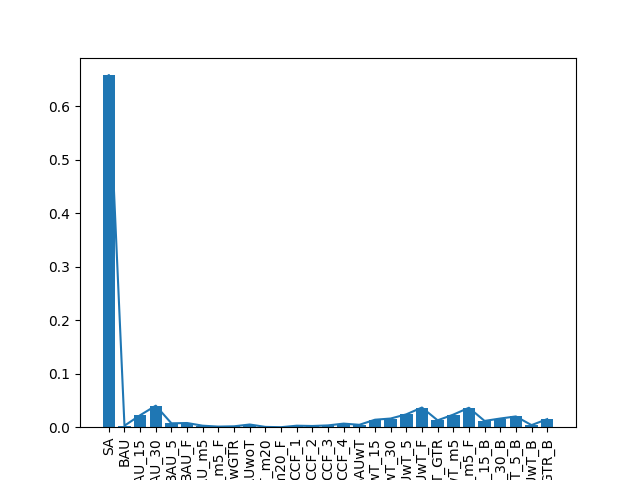

In [47]:
plt.plot([key for key in regimeAmounts.keys()],[val for val in regimeAmounts.values()])

In [48]:
plt.bar(range(len(regimeAmounts)), list(regimeAmounts.values()), align='center')
plt.xticks(range(len(regimeAmounts)), list(regimeAmounts.keys()),rotation="vertical")

([<matplotlib.axis.XTick at 0x7f9c6b0d9310>,
 [Text(0, 0, 'SA'),
  Text(0, 0, 'BAU'),
  Text(0, 0, 'BAU_15'),
  Text(0, 0, 'BAU_30'),
  Text(0, 0, 'BAU_5'),
  Text(0, 0, 'BAU_F'),
  Text(0, 0, 'BAU_m5'),
  Text(0, 0, 'BAU_m5_F'),
  Text(0, 0, 'BAUwGTR'),
  Text(0, 0, 'BAUwoT'),
  Text(0, 0, 'BAUwoT_m20'),
  Text(0, 0, 'BAUwoT_m20_F'),
  Text(0, 0, 'CCF_1'),
  Text(0, 0, 'CCF_2'),
  Text(0, 0, 'CCF_3'),
  Text(0, 0, 'CCF_4'),
  Text(0, 0, 'BAUwT'),
  Text(0, 0, 'BAUwT_15'),
  Text(0, 0, 'BAUwT_30'),
  Text(0, 0, 'BAUwT_5'),
  Text(0, 0, 'BAUwT_F'),
  Text(0, 0, 'BAUwT_GTR'),
  Text(0, 0, 'BAUwT_m5'),
  Text(0, 0, 'BAUwT_m5_F'),
  Text(0, 0, 'BAUwT_15_B'),
  Text(0, 0, 'BAUwT_30_B'),
  Text(0, 0, 'BAUwT_5_B'),
  Text(0, 0, 'BAUwT_B'),
  Text(0, 0, 'BAUwT_GTR_B')])

## Export data as csv

- <b>Solution_alldata</b> contains the optimal regime per stand AND the timely development of indicator values plus all other input columns (represented_are_by_NFIplot, region, NUTS2)
- <b>Solution</b> contains only the selected optimal regime and its share (if multiple regimes per stand are selected)


In [49]:
try:
    os.mkdir("results")
except FileExistsError:
    pass
b = []
c = []
for key in mfo.regimesDecision.keys():
    if mfo.regimesDecision[key].solution_value() > 0:
        b = b+ [(key[0],x*5+2016, key[1]) for x in range(0,21)]
        c = c+ [(key[0],key[1],mfo.regimesDecision[key].solution_value())]
data2b = mfo.data.iloc[mfo.data.index.isin(b)]
data2b.to_csv("./results/solution_alldata_"+scenario+"_"+RCP+"_"+extension+".csv")
c1 = pd.DataFrame(c)
c1.to_csv("./results/solution_"+scenario+"_"+RCP+"_"+extension+".csv")

## Export objective ranges 

Save as json file

In [50]:
import json
mfo.objectiveRanges

with open('./results/objectiveRanges_'+scenario+'_'+RCP+'_'+extension+'.json', 'w') as json_file:
  json.dump(mfo.objectiveRanges, json_file)

Save as CSV.

In [51]:
df = pd.read_json('./results/objectiveRanges_'+scenario+'_'+RCP+'_'+extension+'.json')

df.to_csv('./results/objectiveRanges_'+scenario+'_'+RCP+'_'+extension+'.csv')

## Export objective values
The optimal solution for each objective.

In [52]:
with open("./results/objectiveValues_"+scenario+'_'+RCP+'_'+extension+".csv","w") as file: 
    delim = "" 
    for objName in mfo.objectiveTypes.keys(): 
        file.write(delim+objName) 
        delim = "," 
    file.write("\n") 
    delim = "" 
    for objName in mfo.objectiveTypes.keys(): 
        file.write(delim+str(mfo.objective[objName].solution_value())) 
        delim = "," 
    file.write("\n")